In [6]:
#RUN ONLY ONCE
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import math

In [3]:
#RUN ONLY ONCE
cap = cv2.VideoCapture(0)
    
if not cap.isOpened():
    print("Could not access webcam")

In [45]:

def get_picture_optimized(cap):
    """
    Capture a frame from the webcam, return it as a BGR numpy array.
    """
    
    w = 1920
    h = 1080

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, w)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, h)
    cap.set(cv2.CAP_PROP_EXPOSURE, -5)
    
    time.sleep(0.1)  # let the camera apply settings
    
    ret, frame = cap.read()
    
    if ret:
        return frame
    else:
        print("Failed to capture frame")
        return None

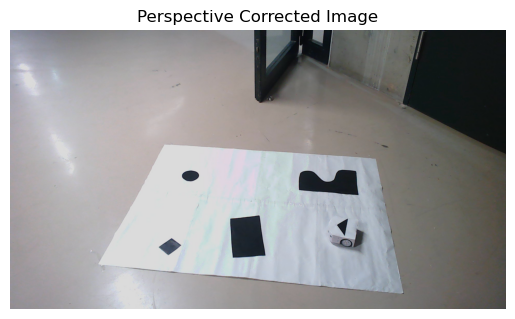

In [46]:
img = get_picture_optimized(cap)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Initial Image")
plt.axis('off')
plt.show()

In [7]:
def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale

In [8]:
#================HYPERPARAMETESRS======================

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 5
B2_O = 20
B3_O = 20
C1_O = 0.3
C2_O = 1.8
M1_O = 8
CL1_O = 2.0
M_O = 2
D_O = 2

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 8
B2_C = 70
B3_C = 70
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 80
B3_T = 80
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
#Min_area_env = 1920*1080*0.01   #Min area in pixel of the env
Min_area_env = 1000
Env_approx = 0.01

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of an obstacle
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.2   #Min area in pixel of the robot
Max_area_rob =  (L_T_p*H_T_p /2) * 1.8
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = True
#========================================================

In [9]:
#Get Image

#EXTRACT PICTURE FROM THE CAMERA
#img = get_picture_optimized(cap)

#LOAD A PICTURE FROM THE REPOSITORY
img = cv2.imread("01.png")
if img is None:
    raise ValueError("ERREUR : impossible de charger IMAGE_TEST1.jpg")

## 1. Vision Pipeline Overview

The vision pipeline is divided into three main stages:

1. **Frame acquisition & environment detection**  
   Capture the global frame, detect the environment, and perform perspective correction.

2. **Obstacle and goal detection**  
   Detect obstacles and the goal on the transformed image to generate an occupancy map.

3. **Robot detection**  
   Identify the robot and compute its orientation.

---

## 2. Image Filtering Pipeline

At each stage, the following filtering operations are applied:

- **Grayscale conversion**  
  Simplifies detection since obstacles are black and the environment is white.

- **Bilateral filtering**  
  Removes noise while keeping edges sharp. Must be tuned carefully to avoid weakening obstacle contours due to shadows.

- **Canny edge detection**  
  Produces a binary edge image The treshold of the canny edge filter is "auto-tuned" according to the image using

  `median_val = np.median(gray)
    lower = int(max(0, c1 * median_val))
    upper = int(min(255, c2 * median_val))`

  which is a comon heuristic to tune gradient threshold.

  If an image is globally bright the intensity value vary over a larger dynamic range and gradient tends to be stranger everywhere.

- **Morphological closing and dilation**  
  Ensures contours are closed for proper contour detection.
 
Filtering parameters must be retuned when the environment or lighting conditions change.  
The contour-based approach is sensitive to noise.

We use different filtering parameters for the different applications because the perspective correction can induce more noice so we nned to be more agressive in filtering.


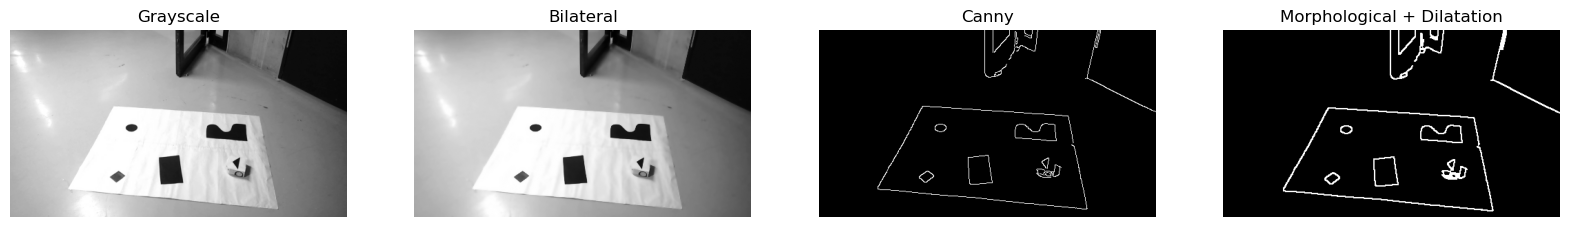

In [10]:
def filter_image(image, b1, b2, b3, c1, c2, m1, cl1, m, d, env = False, dil = True) :
    """
    INPUT : IMAGE AND FILTER PARAMETERS
    OUTPUT : IMAGE FILTERED
    Apply successive filters to a given image : 
    1. Convert to GreyScale
    2. Bilatera filter
    3. Canny edge filter
    4. Morphological filter
    """
    if env :
        image= contour_fixing(image)
        
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Bilateral filter
    filtered_img = cv2.bilateralFilter(gray, b1, b2, b3)

    # Canny edges
    median_val = np.median(gray)
    lower = int(max(0, c1 * median_val))
    upper = int(min(255, c2 * median_val))
    canny_img = cv2.Canny(filtered_img, lower, upper)

    if dil :
        # Morphological filter
        kernel1 = np.ones((m,m), np.uint8)
        kernel2 = np.ones((d,d), np.uint8)
        closed = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, kernel1)
        
        closed = cv2.dilate(closed, kernel2, iterations=1)
        closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel1)

    
        if DEBUG1:
            titles = ["Grayscale", "Bilateral", "Canny", "Morphological + Dilatation"]
            images = [gray, filtered_img, canny_img, closed]
    
            plt.figure(figsize=(20, 10))
            for i, (img, title) in enumerate(zip(images, titles)):
                plt.subplot(1, 4, i+1)
                plt.imshow(img, cmap='gray')
                plt.title(title)
                plt.axis('off')
            plt.show()
        
        return closed
        
    else :
        return canny_img
        
DEBUG1 = True
filtered_image = filter_image(img, B1_O, B2_O , B3_O, C1_O, C2_O, M1_O, CL1_O, M_O, D_O, False)

In [11]:
def orderpoints(pts) :
    """
    Order points of a square counterclockwise
    """
    pts = pts[np.argsort(pts[:, 1]), :]  # Sort by y
    
    top = pts[:2]
    bottom = pts[2:]
    
    # Sort top-left and top-right by x
    if top[0, 0] < top[1, 0]:
        tl, tr = top[0], top[1]
    else:
        tl, tr = top[1], top[0]
        
    # Sort bottom-left and bottom-right by x
    if bottom[0, 0] < bottom[1, 0]:
        bl, br = bottom[0], bottom[1]
    else:
        bl, br = bottom[1], bottom[0]
    
    return np.array([tl, tr, br, bl], dtype="float32")

def find_square(contour, approx, area) :
    """
    Return the shape approximated by a square if the approximation stays in the limit of approx
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)

    if len(cnt) == 4 and cv2.contourArea(cnt) > area and cv2.isContourConvex(cnt):
        find = True
        return find, cnt.reshape(-1,2)
    else : 
        find = False
        return find, None


## 3. Contour Detection

The filtered binary image is passed to `cv2.findContours`, which uses the Suzuki85 algorithm to detect boundaries.

### 3.1 `cv2.findContours`

A contour is a curve connecting continuous boundary points of equal intensity.  
From a binary image, the function extracts these boundaries.

**Output**

- `contours` — list of contours (each contour is an array of `(x, y)` points)  
- `hierarchy` — optional structure describing parent/child relations

### 3.2 Contour Approximation: `cv2.CHAIN_APPROX_SIMPLE`

- Compresses horizontal, vertical, and diagonal segments  
- Keeps only segment endpoints  
- Reduces memory usage without losing important shape information

### 3.3 Contour detection Algorithm (Suzuki85)

1. **Image scanning**  
   The image is scanned left to right, row by row.

2. **Contour start detection**  
   A pixel is a contour start if it is foreground(white) and has a background neighbor(black).
    - The algorithm then follow the contour using  8-connectivity (if an other foreground pixel is here its the next point of the contour)
    - Lable each contour pixel as already part of a contour
    - Stop when we reach the starting point again
- The hierarchy is not used in our pipeline.  
- `CHAIN_APPROX_SIMPLE` already provides simplified but accurate contours.

### 3.4 Practical Use

- The hierarchy is not used in our pipeline.  
- We use `CHAIN_APPROX_SIMPLE` that already provides simplified but accurate contours by only keeping start and end points of straight lines

---


### 4.2 Environment (Rectangle)

Among all four-sided polygons, the largest quadrilateral is selected as the environment.


## 7. Perspective Correction

Perspective correction compensates for camera tilt or misalignment.

### 7.1 Steps

1. Detect the environment rectangle in the initial frame.  
2. Reorder its corners counterclockwise (required for next step)
3. Compute the homography matrix for perspective correction using `matrix = cv2.getPerspectiveTransform(pts1, pts2)` : 

**Homography Matrix Format:**
\begin{bmatrix}
h_0 & h_1 & h_2 \\
h_3 & h_4 & h_5 \\
h_6 & h_7 & 1
\end{bmatrix}

**Mathematical Foundation:**  
Given point \((x, y)\) in `pts1` mapping to \((X, Y)\) in `pts2`:


$x h_0 + y h_1 + h_2 = X (x h_6 + y h_7 + 1)$


$x h_3 + y h_4 + h_5 = Y (x h_6 + y h_7 + 1)$


**Solving Process:**
- 4 point pairs → 8 linear equations
- Forms system $A \mathbf{h} = \mathbf{b}$ (8×8 matrix)
- OpenCV solves using Gaussian elimination [web:21][web:31]

In the end the goal is to have `pts2_point = matrix @ pts1_point`

4. Apply the homography matrix using `warped = cv2.warpPerspective(image, matrix, (SIZE[0], SIZE[1]))` :

For every pixel $(x, y)$ in the image we do :

`src_coords = inv(matrix)` @ [x, y, 1]
Sample pixel value from source location using interpolation : The source point is almost never exactly on a source pixel center.
Neighborhood lookup: The algorithm looks at source pixels around (xs, ys) and computes the output value from them using an interpolation rule.
We used the default interpolation method `cv2.INTER_LINEAR` : Blends the 2×2 neighborhood around (xs, ys) with weights proportional to the distances. Good balance of speed and smoothness; default for warping and resizing.

Fill output image pixel-by-pixel

**Result:** Stable top-down "bird's eye" view of the environment



<Figure size 640x480 with 0 Axes>

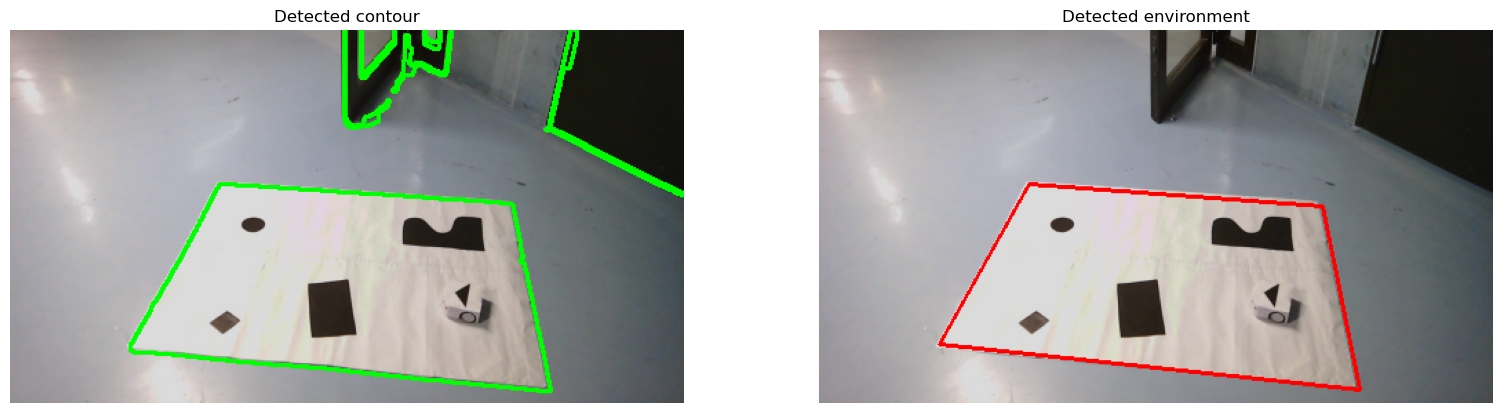

Homography matrix (2 decimals):
[ 5.37  3.01  -1153.41 ]
[ -0.71  9.50  -955.32 ]
[ -0.00  0.01  1.00 ]


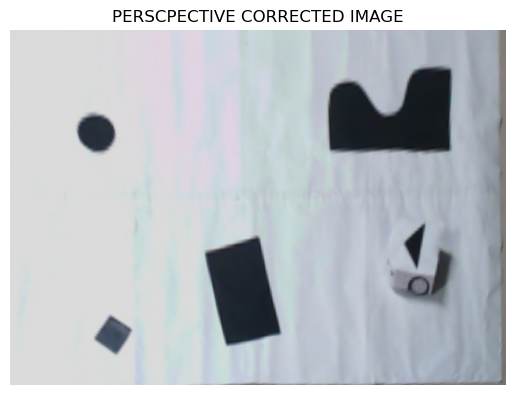

In [12]:
def matrix_perspective(image) :
    """
    Detect the sheet, return the matrix of perspective correction
    """

    filtered_image = filter_image(image, B1_O, B2_O , B3_O, C1_O, C2_O, M1_O, CL1_O, M_O, D_O, False)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG2 :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        
    
    if DEBUG2 : image_plot = image.copy()
        
    squares = []
    for cnt in contours:
        find = False
        find, square = find_square(cnt, Env_approx, Min_area_env)
        if find :
            squares.append(square)
            if DEBUG2 :
                cv2.drawContours(image_plot, [square], -1, (255, 0, 0), 2)

    

    area = 0
    sheet = None
    for square in squares:
        if cv2.contourArea(square) > area :
            sheet = square
            area = cv2.contourArea(square)
    
    if sheet is not None:
        sheet_ordered = orderpoints(sheet)
        tl, tr, br, bl = [tuple(pt.astype(int)) for pt in sheet_ordered]
    else : print("ERROR : SHEET is EMPTY")
    
    pts1 = sheet_ordered
    pts2 = np.array([[0, 0], [SIZE[1]-1, 0], [SIZE[1]-1, SIZE[0]-1], [0, SIZE[0]-1]],dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    
    #DISPLAY
    if DEBUG2:
        titles = ["Detected contour", "Detected environment"]
        images = [image_contours_plot, image_plot]
    
        plt.figure(figsize=(40, 20))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 4, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        plt.show()
        
    print("Homography matrix (2 decimals):")

    for row in matrix:
        print("[", "  ".join(f"{val:.2f}" for val in row), "]")
    return matrix


def convert_perspective(image,matrix) : 
    """
    apply the perspective corrextion
    """
    transformed_image = cv2.warpPerspective(image,matrix,(SIZE[1],SIZE[0]))
    return transformed_image

#COMPUTE THE TRANSFORMATION TO CORRECT PERSPECTIVE
DEBUG1 = False
DEBUG2 = True
matrix = matrix_perspective(img)
#CORRECT THE PERSPECTIVE
transformed_image = convert_perspective(img,matrix)
#PLOTTING
plt.figure()
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("PERSCPECTIVE CORRECTED IMAGE")
plt.axis('off')
plt.show()


In [13]:
def find_triangle(contour, approx, area_min, area_max, image = None) :
    """
    Return the shape approximated by a triangle if the approximation stays in the limit of approx
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)
    
    elem = []
    if len(cnt) == 3 and cv2.contourArea(cnt) > area_min and cv2.contourArea(cnt) < area_max:
        cnt = cnt.reshape(-1, 2)
        elem = cnt
        find = True
        return find, elem
    else : 
        find = False
        return find, elem
    
def altitude_line(TOP, B, C):
    """
    Returns the parametric line of the altitude from base B-C to the TOP vertex.
    """
    Tx, Ty = TOP
    Bx, By = B
    Cx, Cy = C

    # base vector
    ux = Cx - Bx
    uy = Cy - By

    # vector from B to TOP
    wx = Tx - Bx
    wy = Ty - By

    # projection scalar to get foot of altitude
    u_dot_u = ux*ux + uy*uy
    t = (wx*ux + wy*uy) / u_dot_u

    # foot of altitude (on base)
    Px = Bx + t*ux
    Py = By + t*uy

    # direction vector from base to TOP
    vx = Tx - Px
    vy = Ty - Py

    return (Px, Py), (vx, vy)

def order_triangle(P1,P2,P3) :
    """
    Return the corner of the triangle ordered (TOP, LEFT, RIGHT)
    and a confidence indice on how much the triangle is isoscele
    """
    dist_A = math.dist(P1, P2)
    dist_B = math.dist(P2, P3)
    dist_C = math.dist(P3, P1)
    
    diff_A_B = abs(dist_A-dist_B)
    diff_B_C = abs(dist_B-dist_C)
    diff_C_A = abs(dist_C-dist_A)
    
    if diff_A_B < diff_B_C and diff_A_B < diff_C_A :
        TOP = P2
        LEFT = P1
        RIGHT = P3
        confidence = diff_A_B
    elif diff_B_C < diff_A_B and diff_B_C < diff_C_A :
        TOP = P3
        LEFT = P2
        RIGHT = P1
        confidence = diff_B_C
    elif diff_C_A < diff_A_B and diff_C_A < diff_B_C :
        TOP = P1
        LEFT = P3
        RIGHT = P2
        confidence = diff_C_A
    else :
        print("no summit found, adjust threshold")

    ordered = [TOP,LEFT, RIGHT]
    return ordered, confidence

def contour_fixing(image) :
    """
    Fill the border of the image with white pixels to avoid detecting strange contour
    """
    h, w = image.shape[:2]

    # border width
    b = 10

    image[:b, :] = (255, 255, 255)

    image[h-b:h, :] = (255, 255, 255)

    image[:, :b] = (255, 255, 255)

    image[:, w-b:w] = (255, 255, 255)
    return image



### 4.3 Robot (Triangle)

The robot is identified as the triangle with the highest score from the `order_triangle` function,  
which measures how close the polygon is to an isosceles triangle. We compute the minimum difference in length between two segment of the triangle. The smaller this difference the closer we are to an isoscele triangle.

## 8. Robot Orientation

The robot’s orientation is computed using triangle geometry:

1. Compute the altitude line of the triangle.  
2. Identify the top vertex using `order_triangle`.  
3. Derive the orientation vector from the base to te Top vertex from these points.


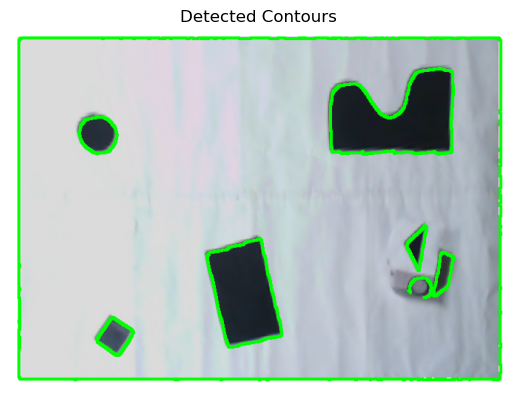

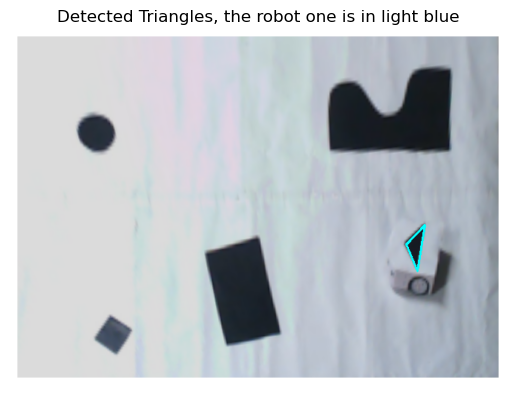

ROBOT FOUND


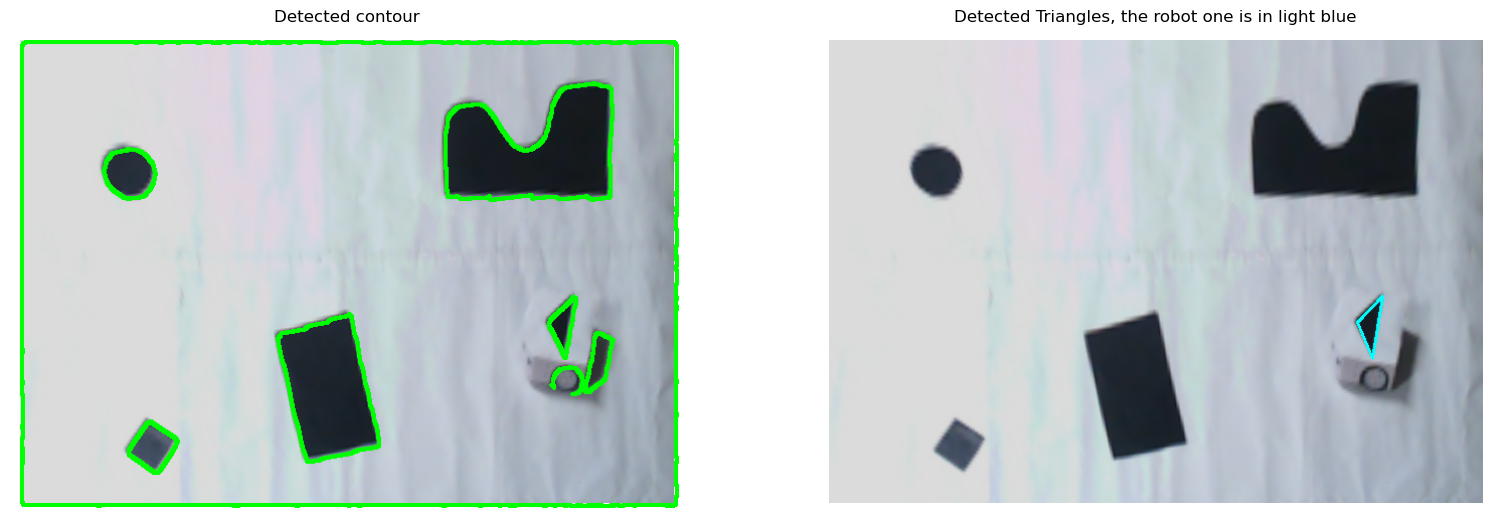

Robot position: (555.28, 293.27)
Robot angle: -2.98 rad


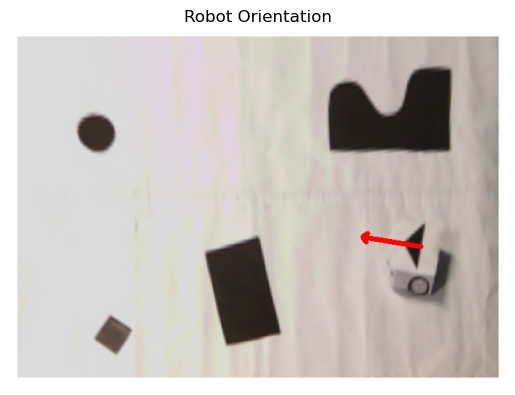

In [14]:
def get_robot(image):
    
    filtered_image = filter_image(image, B1_T, B2_T , B3_T, C1_T, C2_T, M1_T, CL1_T, M_T, D_T, True, True)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG4 :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Detected Contours")
        plt.show()
     
        image_contours = transformed_image.copy()
    
    triangle =[]
    find_t = False
    confidence = 10
    for cnt in contours:
        find_t, tri= find_triangle(cnt, Rob_approx, Min_area_rob, Max_area_rob, image)
        if find_t :
            _, conf = order_triangle(tri[0], tri[1], tri[2])
            if conf < confidence :
                triangle = tri
                confidence = conf
                if DEBUG4 :
                    cv2.drawContours(image_contours, [triangle], -1, (255, 0, 0), 2)

    pos = []
    angle = 0
    if triangle is not None and len(triangle) != 0:
        if DEBUG4 :
            cv2.drawContours(image_contours, [triangle], -1, (255, 255, 0), 2)
            plt.figure()
            plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
            plt.title("Detected Triangles, the robot one is in light blue")
            plt.axis('off')
            plt.show()
            
        tri_ordered,_ = order_triangle(triangle[0], triangle[1], triangle[2])
        alt = altitude_line(tri_ordered[0], tri_ordered[1], tri_ordered[2] )
        pos = alt[0]
        angle = np.atan2(alt[1][1],alt[1][0])
        print("ROBOT FOUND")
        Rob = True
    else :
        print("NO ROBOT FOUND")
        Rob = False



    if DEBUG4:
        titles = ["Detected contour", "Detected Triangles, the robot one is in light blue"]
        images = [image_contours_plot, image_contours]
    
        plt.figure(figsize=(40, 20))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, 4, i+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            #plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')
        plt.show()
        
    return pos, angle, Rob


DEBUG4 = True
robot = get_robot(transformed_image)

x, y = robot[0]
theta = robot[1]

print(f"Robot position: ({x:.2f}, {y:.2f})")
print(f"Robot angle: {theta:.2f} rad")

#PLOTTING
global_map4plot = transformed_image.copy()
if robot[2] :
    length = 80
    end_x = int(robot[0][0] + length * np.cos(robot[1]))
    end_y = int(robot[0][1] + length * np.sin(robot[1]))
    end_point = (end_x, end_y)
    
    robot1 = [int(robot[0][0]),int(robot[0][1])]
    cv2.arrowedLine(global_map4plot, robot1, end_point, color=(255, 2, 2), thickness=5)


plt.imshow(global_map4plot)
plt.title("Robot Orientation")
plt.axis('off')
plt.show()

In [15]:
def find_shape(contour, approx, area_min, area_max = 100000000000) :
    """
    Return the shape approximated according to approx if the area is whithin the treshold
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)
    
    if cv2.contourArea(cnt) > area_min and cv2.contourArea(cnt) < area_max  :
        find = True
        return find, cnt.reshape(-1,2)
    else : 
        find = False
        return find, None
    


def find_circle(contour, min_area, max_area) :
    """
    Return the shape approximated by a circle and its circularity if the shape is whithin the area adn circularity threshold
    """
    (x, y), radius = cv2.minEnclosingCircle(contour)

    area_contour = cv2.contourArea(contour)
    area_circle = np.pi * radius * radius
    find = False
    circularity = area_contour / area_circle
    circle = []
    
    if 0.5 < circularity < 1.9 and (area_circle > min_area and area_circle < max_area):
        
        center = (int(x), int(y))
        radius = int(radius)
        circle = [center,radius]
        find = True
        return find, circle, circularity
    
    return find, circle, circularity

        
def get_inter_shape(shapes):
    """
    Fill the occupancy map with the interior of the shapes with -1
    """
    occupancy = np.zeros((SIZE[0], SIZE[1]))
    for shape in shapes:
        cv2.drawContours(occupancy, [shape], -1, OCCUPIED_SPACE, cv2.FILLED)
    return occupancy




def dist_point_to_segment(px, py, ax, ay, bx, by):
    """Distance from point P to segment AB."""
    A = np.array([ax, ay], dtype=float)
    B = np.array([bx, by], dtype=float)
    P = np.array([px, py], dtype=float)

    AB = B - A
    AP = P - A

    t = np.dot(AP, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)  # projection inside segment

    closest = A + t * AB
    return np.linalg.norm(P - closest)

def dist_point_to_polygon(px, py, polygon):
    """Polygon = list/array of (x,y)."""
    min_dist = float('inf')
    n = len(polygon)

    for i in range(n):
        x1, y1 = polygon[i]
        x2, y2 = polygon[(i+1) % n]
        d = dist_point_to_segment(px, py, x1, y1, x2, y2)
        if d < min_dist:
            min_dist = d

    return min_dist
    




### 4.4 Goal (Circle)

For each contour:

1. Compute its **minimum enclosing circle**.  
2. Compute the **area ratio**:  

$\text{ratio} = \frac{\text{circle area}}{\text{contour area}}$

The most circular shape (lowest ratio) is selected as the **goal**.

### 5.4 Obstacles

Remaining shapes (neither robot nor goal) are classified as **obstacles**, using:

- Polygon approximation  
- Area thresholds




## 6. Occupancy Map Construction

We generate an occupancy grid with the same dimensions as the processed image by filling the detected shapes :

A circular mask is applied to the goal : 

dist_mask = $(X - cx)^2 + (Y - cy)^2 <= radius^2$

map_[dist_mask] = GOAL

The obstacles are filled using cv2.drawContours(occupancy, [shape], -1, 1, cv2.FILLED)


- `0` → free space  
- `-1` → obstacle  
- `-3` → goal  

A one-pixel border of `-1` surrounds the map to prevent the robot from leaving the environment.

---

## 9. Overlapping Management

Sometimes the goal is mistakenly classified as an obstacle.  
To fix this, obstacles whose vertices lie inside the goal area are removed from the obstacle set.

---



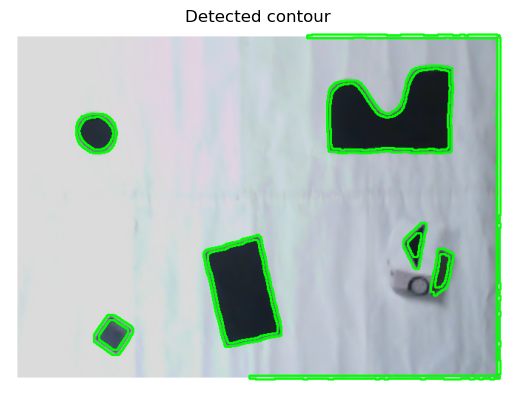

ROBOT FOUND


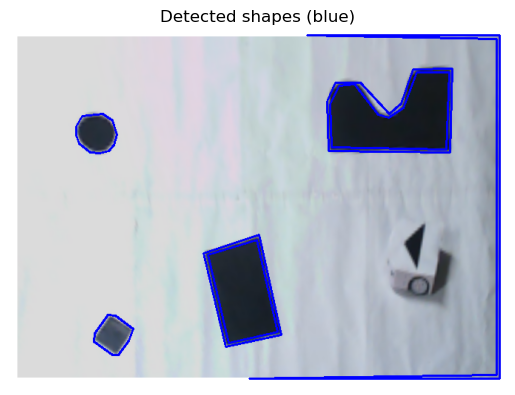

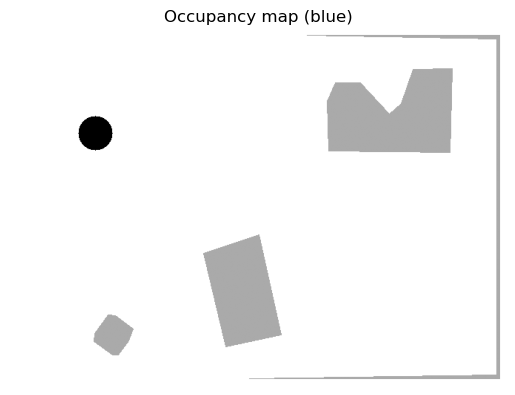

MAP ANALYZED : 
GOAL FOUND


In [22]:
def get_map(image) :

    filtered_image = filter_image(image, B1_C, B2_C , B3_C, C1_C, C2_C, M1_C, CL1_C, M_C, D_C, True)
   
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG3 :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Detected contour")
        plt.show()  
        image_contours = transformed_image.copy()

    
    robot_pos,_, Rob = get_robot(image)

    shapes =[]
    find_s = False
    find_circ = False
    confidence = 100
    for cnt in contours:
        find_s, shape= find_shape(cnt, Obs_approx, Min_area_obs, Max_area_obs)
        find_c, circle_pot, confidence_pot = find_circle(cnt, Min_area_goal, Max_area_goal)
        if find_s :
            if dist_point_to_polygon(robot_pos[0], robot_pos[1], shape) > R_ROBOT_p :
                shapes.append(shape)
                if DEBUG3 : cv2.drawContours(image_contours, [shape], -1, (255, 0, 0), 2)
        if find_c:
            if Rob : 
                # compute distance between robot and circle
                cx, cy = circle_pot[0]
                rx, ry = robot_pos
                dist = np.hypot(cx - rx, cy - ry)
                # ignore circle if too close to robot
                if abs(confidence_pot - 1) < confidence and dist > R_ROBOT_p:
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True
            else :
                if abs(confidence_pot - 1) < confidence :
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True

    if find_circ:
        cx, cy = circle[0]
        r = circle[1]

        shapes = [
            sh for sh in shapes
            if dist_point_to_polygon(cx, cy, sh) > r+10
            ]

   
    if DEBUG3 :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
        plt.title("Detected shapes (blue)")
        plt.axis('off')
        plt.show()
    
    map_ = get_inter_shape(shapes)

    
    if find_circ :
        if DEBUG3 :
            cv2.circle(image_contours, circle[0], circle[1], (0, 255, 0), -1)
            
        (cx, cy) = circle[0]
        radius = circle[1]
        # Dimensions
        h, w = map_.shape
    
        # Grille de coordonnées
        Y, X = np.ogrid[:h, :w]
    
        # Condition du disque (distance <= rayon)
        dist_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2
    
        # Application
        map_[dist_mask] = GOAL
    
        
        map_[cy,cx] = GOAL
        
    if DEBUG3 :    
        plt.imshow(map_, cmap='gray')
        plt.title("Occupancy map (blue)")
        plt.axis('off')
        plt.show()

    print("MAP ANALYZED : ")
    if find_circ:
       print("GOAL FOUND")
    else:
        print("NO GOAL DETECTED")
       
    return map_
DEBUG3 = True
DEBUG4 = False
global_map = get_map(transformed_image)



## 6. Occupancy Map Construction

We generate an occupancy grid with the same dimensions as the processed image by filling the detected shapes :

A circular mask is applied to the goal : 

dist_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2

map_[dist_mask] = GOAL

The obstacles are filled using cv2.drawContours(occupancy, [shape], -1, 1, cv2.FILLED)


- `0` → free space  
- `-1` → obstacle  
- `-3` → goal  

A one-pixel border of `-1` surrounds the map to prevent the robot from leaving the environment.

---



## 8. Robot Orientation

The robot’s orientation is computed using triangle geometry:

1. Compute the altitude line of the triangle.  
2. Identify the top vertex using `order_triangle`.  
3. Derive the orientation vector from the base to te Top vertex from these points.

---

## 9. Overlapping Management

Sometimes the goal is mistakenly classified as an obstacle.  
To fix this, obstacles whose vertices lie inside the goal area are removed from the obstacle set.

---

## 10. Remarks and Limitations

- Coordinate origin is at the top-left corner.  
- `x` increases to the right, `y` increases downward.  
- Filtering parameters may need adjustment under different lighting conditions.*

In [1]:
#ON WHAT PICTURE DO I WANT TO WORK

#EXTRACT PICTURE FROM THE CAMERA
#img = get_picture_optimized(cap)

#LOAD A PICTURE FROM THE REPOSITORY
img = cv2.imread("01.png")
if img is None:
    raise ValueError("ERREUR : impossible de charger IMAGE_TEST1.jpg")

#COMPUTE THE TRANSFORMATION TO CORRECT PERSPECTIVE
matrix = matrix_perspective(img)

#CORRECT THE PERSPECTIVE
transformed_image = convert_perspective(img,matrix)

#PLOTTING
plt.figure()
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("Perspective Corrected Image")
plt.axis('off')
plt.show()

#TO GET THE OCCUPANCY MAP + GOAL:
global_map = get_map(transformed_image)

#TO GET ROBOT POSITION
robot = get_robot(transformed_image)
print(robot)

#PLOTTING
global_map4plot = global_map.copy()
if robot[2] :
    length = 100
    end_x = int(robot[0][0] + length * np.cos(robot[1]))
    end_y = int(robot[0][1] + length * np.sin(robot[1]))
    end_point = (end_x, end_y)
    
    robot1 = [int(robot[0][0]),int(robot[0][1])]
    cv2.arrowedLine(global_map4plot, robot1, end_point, color=(2, 2, 2), thickness=10)


plt.imshow(global_map4plot)
plt.axis('off')
plt.show()

NameError: name 'cv2' is not defined

In [ ]:
cv2.imwrite('output.png', img)



## 6. Occupancy Map Construction

We generate an occupancy grid with the same dimensions as the processed image by filling the detected shapes :

A circular mask is applied to the goal : 

dist_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2

map_[dist_mask] = GOAL

The obstacles are filled using cv2.drawContours(occupancy, [shape], -1, 1, cv2.FILLED)


- `0` → free space  
- `-1` → obstacle  
- `-3` → goal  

A one-pixel border of `-1` surrounds the map to prevent the robot from leaving the environment.

---



## 8. Robot Orientation

The robot’s orientation is computed using triangle geometry:

1. Compute the altitude line of the triangle.  
2. Identify the top vertex using `order_triangle`.  
3. Derive the orientation vector from the base to te Top vertex from these points.

---

## 9. Overlapping Management

Sometimes the goal is mistakenly classified as an obstacle.  
To fix this, obstacles whose vertices lie inside the goal area are removed from the obstacle set.

---

## 10. Remarks and Limitations

- Coordinate origin is at the top-left corner.  
- `x` increases to the right, `y` increases downward.  
- Filtering parameters may need adjustment under different lighting conditions.*

## 1. Vision Pipeline Overview

The vision pipeline is divided into three main stages:

1. **Frame acquisition & environment detection**  
   Capture the global frame, detect the environment, and perform perspective correction.

2. **Obstacle and goal detection**  
   Detect obstacles and the goal on the transformed image to generate an occupancy map.

3. **Robot detection**  
   Identify the robot and compute its orientation.

---

## 2. Image Filtering Pipeline

At each stage, the following filtering operations are applied:

- **Grayscale conversion**  
  Simplifies detection since obstacles are black and the environment is white.

- **Bilateral filtering**  
  Removes noise while keeping edges sharp. Must be tuned carefully to avoid weakening obstacle contours due to shadows.

- **Canny edge detection**  
  Produces a binary edge image The treshold of the canny edge filter is "auto-tuned" according to the image using

  `median_val = np.median(gray)
    lower = int(max(0, c1 * median_val))
    upper = int(min(255, c2 * median_val))`

  which is a comon heuristic to tune gradient threshold.

  If an image is globally bright the intensity value vary over a larger dynamic range and gradient tends to be stranger everywhere.

- **Morphological closing and dilation**  
  Ensures contours are closed for proper contour detection.
 
Filtering parameters must be retuned when the environment or lighting conditions change.  
The contour-based approach is sensitive to noise.

We use different filtering parameters for the different applications because the perspective correction can induce more noice so we nned to be more agressive in filtering.
---

## 3. Contour Detection

The filtered binary image is passed to `cv2.findContours`, which uses the Suzuki85 algorithm to detect boundaries.

### 3.1 `cv2.findContours`

A contour is a curve connecting continuous boundary points of equal intensity.  
From a binary image, the function extracts these boundaries.

**Output**

- `contours` — list of contours (each contour is an array of `(x, y)` points)  
- `hierarchy` — optional structure describing parent/child relations

### 3.2 Contour Approximation: `cv2.CHAIN_APPROX_SIMPLE`

- Compresses horizontal, vertical, and diagonal segments  
- Keeps only segment endpoints  
- Reduces memory usage without losing important shape information

### 3.3 Contour detection Algorithm (Suzuki85)

1. **Image scanning**  
   The image is scanned left to right, row by row.

2. **Contour start detection**  
   A pixel is a contour start if it is foreground(white) and has a background neighbor(black).
    - The algorithm then follow the contour using  8-connectivity (if an other foreground pixel is here its the next point of the contour)
    - Lable each contour pixel as already part of a contour
    - Stop when we reach the starting point again
- The hierarchy is not used in our pipeline.  
- `CHAIN_APPROX_SIMPLE` already provides simplified but accurate contours.

### 3.4 Practical Use

- The hierarchy is not used in our pipeline.  
- We use `CHAIN_APPROX_SIMPLE` that already provides simplified but accurate contours by only keeping start and end points of straight lines

---

## 4. Shape Classification

We aim to recognize:

- the **environment rectangle**  
- the **robot triangle**  
- the **goal circle**
- the **obstacles**

### 4.1 Polygon Approximation

For each contour, we approximate the contour :

approx = cv2.approxPolyDP(contour, approx_factor * contour_length, True)

The approx factor (a percentage of the perimeter of the contour) was determined experimentaly.

The number of vertices in the approximation helps classify the shape.

In addition every shape recognition is coupled with a area treshold (upper, lower or both) to remove unpossible shapes that can be detected such as : noise (small area), big obstacles kinda circular, big triangles.

### 4.2 Environment (Rectangle)

Among all four-sided polygons, the largest quadrilateral is selected as the environment.

### 4.3 Robot (Triangle)

The robot is identified as the triangle with the highest score from the `order_triangle` function,  
which measures how close the polygon is to an isosceles triangle. We compute the minimum difference in length between two segment of the triangle. The smaller this difference the closer we are to an isoscele triangle.

### 4.4 Goal (Circle)

For each contour:

1. Compute its **minimum enclosing circle**.  
2. Compute the **area ratio**:  

   \[
   \text{ratio} = \frac{\text{circle area}}{\text{contour area}}
   \]

The most circular shape (lowest ratio) is selected as the **goal**.

### 5.4 Obstacles

Remaining shapes (neither robot nor goal) are classified as **obstacles**, using:

- Polygon approximation  
- Area thresholds


---

## 7. Perspective Correction

Perspective correction compensates for camera tilt or misalignment.

### 7.1 Steps

1. Detect the environment rectangle in the initial frame.  
2. Reorder its corners counterclockwise (required for next step)
3. Compute the homography matrix for perspective correction using `matrix = cv2.getPerspectiveTransform(pts1, pts2)` : 

**Homography Matrix Format:**
\begin{bmatrix}
h_0 & h_1 & h_2 \\
h_3 & h_4 & h_5 \\
h_6 & h_7 & 1
\end{bmatrix}

**Mathematical Foundation:**  
Given point \((x, y)\) in `pts1` mapping to \((X, Y)\) in `pts2`:

\[
x h_0 + y h_1 + h_2 = X (x h_6 + y h_7 + 1)
\]
\[
x h_3 + y h_4 + h_5 = Y (x h_6 + y h_7 + 1)
\]

**Solving Process:**
- 4 point pairs → 8 linear equations
- Forms system \(A \mathbf{h} = \mathbf{b}\) (8×8 matrix)
- OpenCV solves using Gaussian elimination [web:21][web:31]

In the end the goal is to have `pts2_point = matrix @ pts1_point`

4. Apply the homography matrix using `warped = cv2.warpPerspective(image, matrix, (SIZE[0], SIZE[1]))` :

For every pixel \((x, y)\) in the image we do :
src_coords = inv(matrix) @ [x, y, 1]
Sample pixel value from source location using interpolation : The source point is almost never exactly on a source pixel center.
Neighborhood lookup: The algorithm looks at source pixels around (xs, ys) and computes the output value from them using an interpolation rule.
We used the default interpolation method `cv2.INTER_LINEAR` : Blends the 2×2 neighborhood around (xs, ys) with weights proportional to the distances. Good balance of speed and smoothness; default for warping and resizing.

Fill output image pixel-by-pixel

**Result:** Stable top-down "bird's eye" view of the environment

---

## 6. Occupancy Map Construction

We generate an occupancy grid with the same dimensions as the processed image by filling the detected shapes :

A circular mask is applied to the goal : 

dist_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2

map_[dist_mask] = GOAL

The obstacles are filled using cv2.drawContours(occupancy, [shape], -1, 1, cv2.FILLED)


- `0` → free space  
- `-1` → obstacle  
- `-3` → goal  

A one-pixel border of `-1` surrounds the map to prevent the robot from leaving the environment.

---



## 8. Robot Orientation

The robot’s orientation is computed using triangle geometry:

1. Compute the altitude line of the triangle.  
2. Identify the top vertex using `order_triangle`.  
3. Derive the orientation vector from the base to te Top vertex from these points.

---

## 9. Overlapping Management

Sometimes the goal is mistakenly classified as an obstacle.  
To fix this, obstacles whose vertices lie inside the goal area are removed from the obstacle set.

---

## 10. Remarks and Limitations

- Coordinate origin is at the top-left corner.  
- `x` increases to the right, `y` increases downward.  
- Filtering parameters may need adjustment under different lighting conditions.*

# Motion control
## 1. Transform path
The global path is given to the motion control module. There it is converted into distances in mm instead of pixel.
Then points that are on one straight line are removed to have only a small number of waypoints at the turning points.
To follow the path we try to reach these waypoints and aim for the next waypoint if one is reached. To make it feasible and avoid turning in place a small tolerance of 1.2cm is allowed to count a waypoint as reached.

## 2. Movement
If the movement to the next point is straight, only a constant velocity $v_{cmd}$ is set. If there is a small turn necessary, the differential velocity for the turn is added to/substracted from the constant forward velocity resulting in $v_{motor,left} = v_{cmd}+w_{turn}$.
If a big turn is needed, the robot stops and turns in place to be able to follow tighter turns.
Proportional control is used to achieve the right turn velocity $\omega = K * (desiredAngle - filteredAngle)$ and the maximum output velocity is clipped to $v_{max}$, to prevent the robot from going too fast.
No more complex motion control is necessary, as we simplify our path to fit going straight and then turning in place and going straight again.
If more complex trajectories are given or higher precision is necessary, the motion control would need to be adapted with PID control.

## 3. Kidnapping
In case of kidnapping, we recompute the distance of the position of the robot from the filtering to all the waypoints in our trajectory.
Then we restart on our path by going to the closest waypoint and then we continue on our path like normal.
Here we assume that out path covers all free spaces between obstacles and no places can be found, where the robot could choose a waypoint with an obstacle between itself and this waypoint.


# Ekf calibrations
## 1. Conversion of thymio wheel speeds to mm/s
This was tested on the striped paper and with the logic of exercise 8. The resulting conversion of 0.43mm/thymio-units is used.

## 2. Wheel speed variancce
The variance of the wheel speeds is measured once while going straight and once while turning each with constant velocity commands.
The variance in speed is taken from those runs and equally divided on measurement and process (velocity command) noise.

## 3. Camera variance
The variance of the camera in x, y and $\theta$ is derived by taking the variance over the measurements of 100 pictures of the same robot position.

## 4. Process noise
For all states a small value is used as process noise to account for model mismatch and random walk.
These uncertainties are low, but are necessary to allow for not trusting the prediction model absolutely.


